In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import bds
from arch import arch_model
import warnings
import matplotlib.colors as mcolors

warnings.filterwarnings('ignore')

## Step 0
### Data Acquisition

In [2]:
tickers_market = ['SPY']
tickers_energy = ['XLE', 'XOP']
tickers_gold = ['GDX', 'GLD']
tickers_tech = ['IYW', 'XLK']

start = '2017-01-01'
end = '2022-01-01'

data_market = yf.download(tickers_market, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_energy = yf.download(tickers_energy, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_gold = yf.download(tickers_gold, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_tech = yf.download(tickers_tech, start=start, end=end, progress=False, auto_adjust=True)["Close"]  # type: ignore

prices = pd.concat([data_market, data_energy, data_gold, data_tech], axis=1)
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()
rets

Ticker,SPY,XLE,XOP,GDX,GLD,IYW,XLK
Date,,,,,,,
2017-01-04,0.005932,-0.002103,0.004749,0.007326,0.003524,0.004447,0.003478
2017-01-05,-0.000795,-0.002503,-0.003085,0.056753,0.015396,0.001560,0.001633
2017-01-06,0.003571,0.000923,-0.007394,-0.035538,-0.007400,0.009473,0.007314
2017-01-09,-0.003306,-0.014601,-0.028411,0.003121,0.008199,0.002840,-0.000202
2017-01-10,0.000000,-0.009134,0.000000,0.007099,0.004251,0.000324,0.000202
...,...,...,...,...,...,...,...
2021-12-27,0.014053,0.021622,0.039652,0.000958,0.002364,0.020187,0.021226
2021-12-28,-0.000817,-0.000713,-0.008699,-0.007690,-0.004319,-0.008060,-0.005222
2021-12-29,0.001278,-0.006442,-0.004072,0.004173,-0.000297,-0.000431,0.000853


## Step 1
### Foundational Analysis, part A: BDS test on residuals of pairs trading returns


Our pair-trading strategy is based on a linear relationship between the pair, 
the spread might have nonlinear relationships that we miss when we 
decide to model it linearly. We should verify we are not missing important 
nonlinear patterns in the spread, to do so we will employ the BDS test.

The trick is that if there are nonlinear relationships, the residuals of our 
linear model will not be random, they will have a discernible nonlinear 
pattern. So to check for nonlinearity, what we really will check is whether the 
residuals of our linear fit, are random (in which case there is no extra pattern 
or nonlinearity) or not.


if the data is random (  and independent and identically distributed), then the probability of two $m$-dimensional points being close equals the probability of their one-dimensional components being close, raised to the $m^{th}$ power:

$$C_m(\epsilon) = [C_1(\epsilon)]^m$$

Violations of this indicate nonlinear relationships. The BDS statistic 
is given by:

$$BDS_{m,\epsilon} = \sqrt{T_m} \frac{C_m(\epsilon) - [C_1(\epsilon)]^m}{\sigma_{m,\epsilon}}$$

where

**Embedding dimension ($m$)**:We embed our 1 dimensional residuals into a higher dimensional system,
 it is standard to test multiple dimensions as since different dependencies appear at different scales. 

**Distance parameter ($\epsilon$)**: Typically taking as multiples of the standard deviation

**Number m-dimensional vectors ($T_m$)**: The 1 dimensional data is embedded into
$m$ dimensions and then split into $T_m$ m-dimensional arrays

**Asymptotic standard deviation of the numerator ($\sigma_{m,\epsilon}$)**:
Normalization factor 

Under the null of independence, this follows a standard normal distribution. In 
simple words  we consider there will be nonlinear relationships if 
$|z|>1.96$ with a $95\%$ confidence. Similarly a p-value $p<0.05$ will tell
us the data is not random

In [3]:
## Code to run the BDS on the residuals
def bds_residuals(ticker1,ticker2):
    # OLS regression and spread
    y = rets[ticker1]
    X = sm.add_constant(rets[ticker2])
    model_energy = sm.OLS(y, X).fit()
    alpha_energy, beta_energy = model_energy.params
    spread_energy = y - (alpha_energy + beta_energy * rets[ticker2])
    spread_energy.name = "Spread"
    print(f"{ticker1} on {ticker2} Regression beta coefficient: ", beta_energy)
    m_vals  = list(range(2,10))
    eps_mul = [0.25* i for i in range(1,8)]
    rows = []
    for m in m_vals:
        for k in eps_mul:
            stats, pvals = bds(y.to_numpy(), max_dim=m, epsilon=k *spread_energy.std())
            z = float(np.atleast_1d(stats)[-1])
            p = float(np.atleast_1d(pvals)[-1])
            rows.append({"m": m, "ε": f"{k:.1f}σ", "z": z, "p": p})
    bds_filt = pd.DataFrame(rows)
    print(f"We obtain an average p value of {bds_filt['p'].mean()}")
    return bds_filt
## PLOTTING FUNCTIONS
def make_pivot(df: pd.DataFrame, value: str) -> pd.DataFrame:
    """Return a m × epsilon table ready for imshow."""
    tbl = df.copy()
    # strip the trailing 'σ' and cast to float so eps is numeric & sortable
    tbl["eps_float"] = tbl["ε"].str.rstrip("σ").astype(float)
    tbl = tbl.pivot(index="m", columns="eps_float", values=value)
    # ensure natural order (increasing m downward, ε across)
    tbl.sort_index(axis=0, inplace=True)
    tbl.sort_index(axis=1, inplace=True)
    return tbl

def plot_bds_heatmaps(bds_data: pd.DataFrame):
    """Generates side-by-side heatmaps for BDS z-scores."""
    filt_piv = make_pivot(bds_data, "z")
    
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=110)

    # Plot 1: Standard heatmap with default color scale
    im1 = ax1.imshow(filt_piv, aspect="auto", cmap='viridis')
    ax1.set_title("BDS z-scores: GARCH(1,1) residuals")
    ax1.set_xticks(np.arange(len(filt_piv.columns)))
    ax1.set_xticklabels(filt_piv.columns)
    ax1.set_yticks(np.arange(len(filt_piv.index)))
    ax1.set_yticklabels(filt_piv.index)
    ax1.set_xlabel("ε (in σ units)")
    ax1.set_ylabel("Embedding dimension m")
    fig.colorbar(im1, ax=ax1, label="z-score")

    # Plot 2: Heatmap with custom color scale for significance
    bounds = [-1000, -1.96, 1.96, 1000]
    cmap = mcolors.ListedColormap(['red', 'green', 'pink'])
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)
    
    im2 = ax2.imshow(filt_piv, aspect="auto", cmap=cmap, norm=norm)
    ax2.set_title("BDS z-scores: Highlighted Rejection Region")
    ax2.set_xticks(np.arange(len(filt_piv.columns)))
    ax2.set_xticklabels(filt_piv.columns)
    ax2.set_yticks(np.arange(len(filt_piv.index)))
    ax2.set_yticklabels(filt_piv.index)
    ax2.set_xlabel("ε (in σ units)")
    ax2.set_ylabel("Embedding dimension m")
    
    cbar = fig.colorbar(im2, ax=ax2, label="z-score")
    cbar.set_ticks([-1.96, 0, 1.96])
    cbar.set_ticklabels(['< -1.96', '0', '> 1.96'])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()

####  Energy ETFs

XLE on XOP Regression beta coefficient:  0.6396327862865385
We obtain an average p value of 9.543803928791849e-05


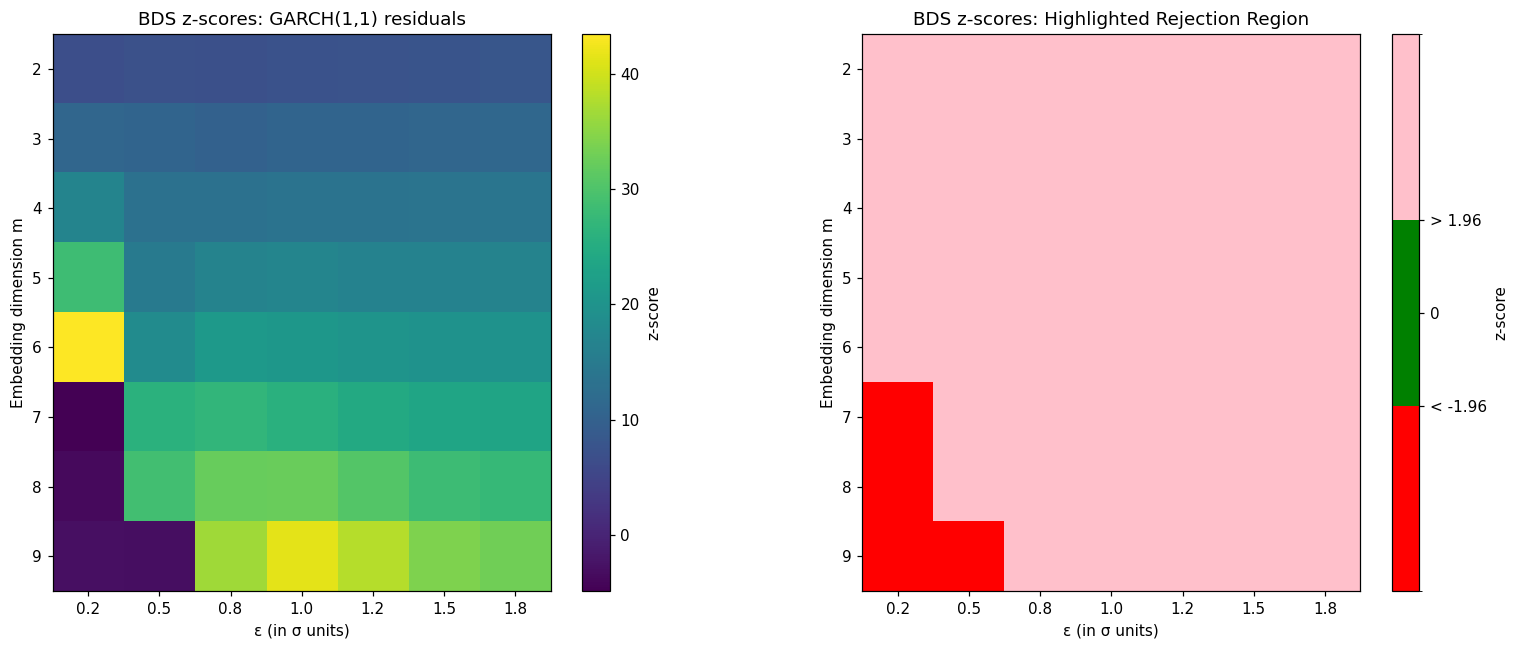

In [4]:
bds_energy = bds_residuals("XLE","XOP")
plot_bds_heatmaps(bds_energy)

The plot on the left is a heat map for the $Z-scores$ of the $BDS$ test while
the one on the right forgets about the particular value and just signals the 
areas there the residuals are random (in green) or where there is a nonlinear 
dependence (pink and red), as we can see in this particular instance there is 
always nonlinear relations along the scales tested. The high values of the 
$Z-score$ point out that volatility clustering might be the main suspect [1,3] 
before checking this using  the statmodels library [2]. Let us see if the 
same happens in the other datasets

####  Gold ETFs

GDX on GLD Regression beta coefficient:  1.9541563766345587
We obtain an average p value of 0.004732101893608454


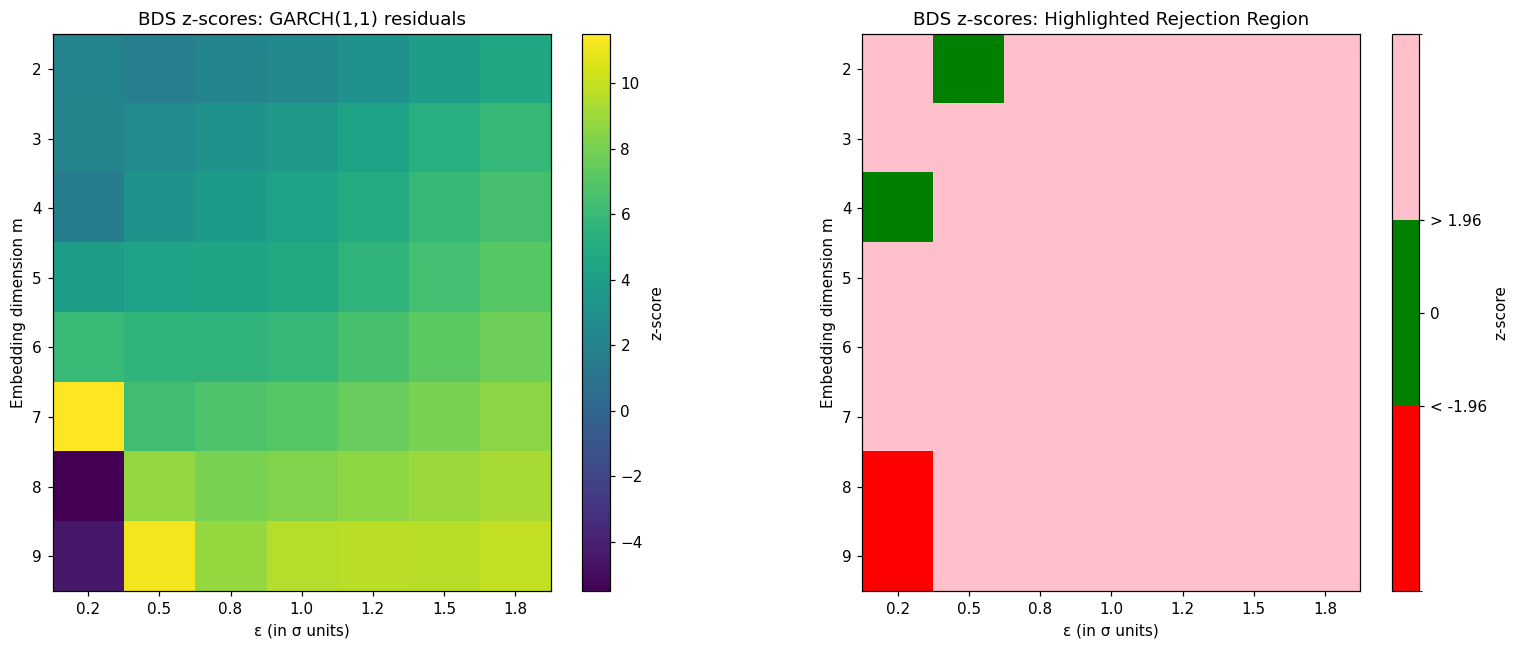

In [5]:
bds_gold = bds_residuals("GDX","GLD")
plot_bds_heatmaps(bds_gold)

In this case we see two small regions where the data seems to be linear, 
unfortunately this seems related to small scales, which are 
short lived thus our data is essentially nonlinear in all regimes of practical
interest except for thus relevant for high frequency trading which is not 
part of our strategy

### Tecnhnology ETFs

IYW on XLK Regression beta coefficient:  0.9986177988005368
We obtain an average p value of 0.0003746727450674369


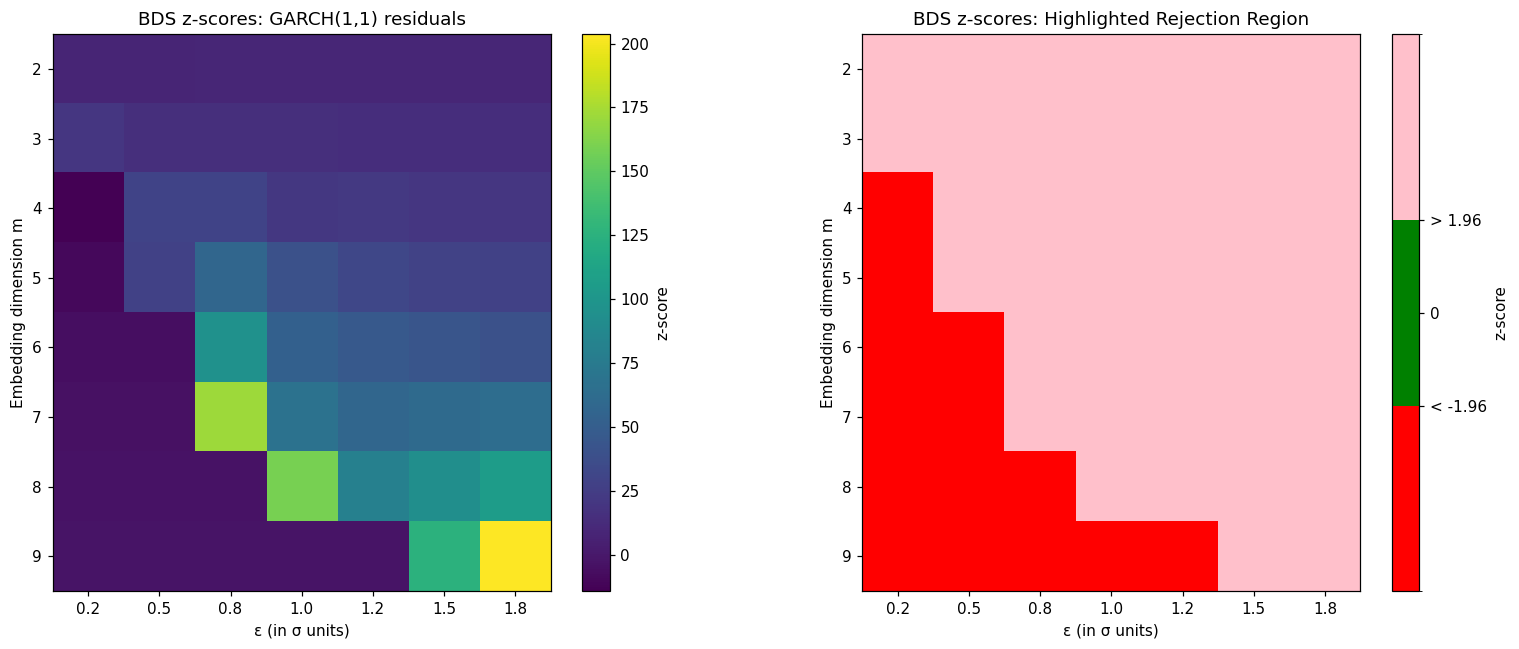

In [6]:
bds_tech = bds_residuals("IYW","XLK")
plot_bds_heatmaps(bds_tech)

Again there is no regime where a linear relationship fully captures the pair, 
this is disappointing considering we want to exploit this for a pair trading 
strategy. On the other hand, the nonlinear relation we are missing might be 
volatility clustering, which mainly happens in stressed markets, if that is the 
case we can still use the spread to do a pair trading strategy, since we can 
monitor the state of the market via the VIX or some other indicator or signal, 
the fact that we do not capture volatility clustering might not be an issue as 
long as we are aware we our model does not capture most of the variability
of the spread in the trading pair in that particular situation, this can be 
addressed by halting the trading strategy in that regime.

# Removing Volatility clustering

We will apply prefiltering in our residuals using a GARCH(1,1) models to isolate 
truly non-linear dependencies from mere volatility clustering. If our pair spread
residuals are random after this procedure, we can apply our linear pair trading 
strategy knowing there is no extra nonlinear pattern we are missing.


In [7]:
def bds_residuals_garch(ticker1,ticker2):
    # OLS regression and spread
    y = rets[ticker1]
    X = sm.add_constant(rets[ticker2])
    model_energy = sm.OLS(y, X).fit()
    alpha_energy, beta_energy = model_energy.params
    spread_energy = y - (alpha_energy + beta_energy * rets[ticker2])
    spread_energy.name = "Spread"
    print(f"{ticker1} on {ticker2} Regression beta coefficient: ", beta_energy)
    garch = arch_model(100*spread_energy, p=1, q=1, mean="Zero")
    fit = garch.fit(disp="off")
    std_resid = fit.std_resid /100
    m_vals  = list(range(2,10))
    eps_mul = [0.25* i for i in range(1,8)]
    rows = []
    for m in m_vals:
        for k in eps_mul:
            stats, pvals = bds(std_resid.to_numpy(), max_dim=m, epsilon=k *spread_energy.std())
            z = float(np.atleast_1d(stats)[-1])
            p = float(np.atleast_1d(pvals)[-1])
            rows.append({"m": m, "ε": f"{k:.1f}σ", "z": z, "p": p})
    bds_filt = pd.DataFrame(rows)
    print(f"We obtain a p value of {bds_filt['p'].mean()}")
    return bds_filt
def plot_reduction(piv,piv2):
    raw_flat  = make_pivot(piv,"z").stack()
    filt_flat = make_pivot(piv2,"z").stack()
    reduction = (np.abs(raw_flat) - np.abs(filt_flat)).rename("Δ|z| (raw – filt)")
    plt.figure(figsize=(12,6),dpi=110)
    reduction.plot(kind="bar")
    plt.title("Drop in absolute z‑score after GARCH filtering")
    plt.xlabel("(m, ε) pair")
    plt.ylabel("Reduction in |z|")
    plt.tight_layout()
    plt.show()

### Energy ETFs

XLE on XOP Regression beta coefficient:  0.6396327862865385
We obtain a p value of 0.6382588521913581


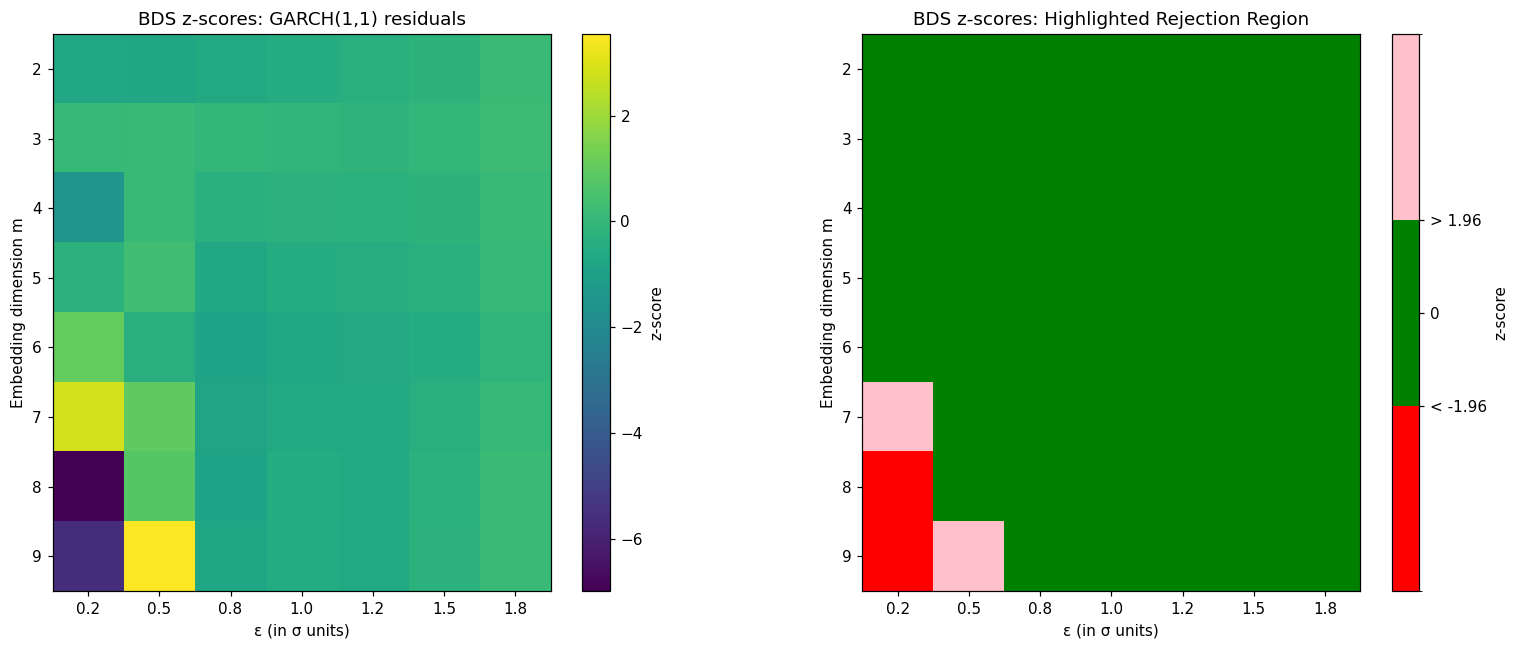

In [8]:
bds_energy_garch = bds_residuals_garch("XLE","XOP")
plot_bds_heatmaps(bds_energy_garch)

Our residuals are mostly random except for the lower left corner, which 
corresponds to fast signal changes (small $\epsilon$) that persist over time (large $m$) [3,4], 
and is outside our scales of interest as we trade over long horizon so the fast 
changes do not matter as much, therefore our linear model for pair
trading can be used with confidence in this pair as long as we are aware that 
volatility clustering might dominate it and should 
be monitored to complement the model, we can visualize how much our $z-scores$
dropped by using garch to exclude volatility clustering

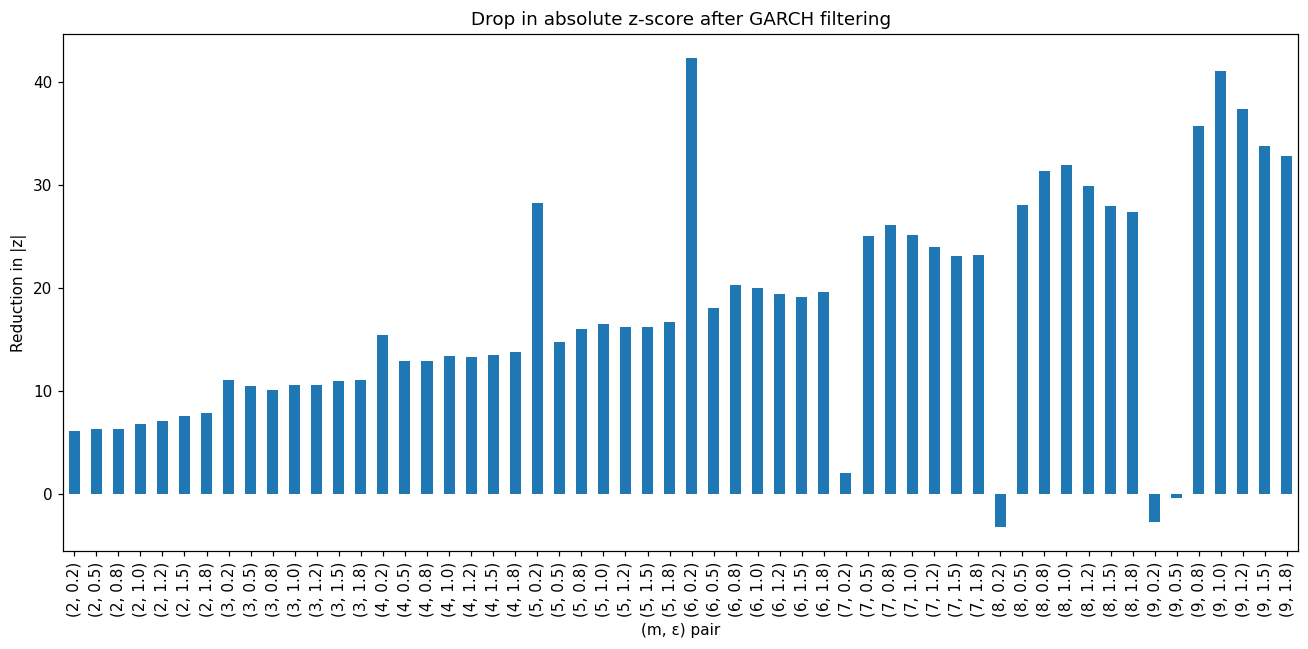

In [9]:
plot_reduction(bds_energy,bds_energy_garch)

The fact that the $Z-scores$ were as high as 40 and dropped all the way to $|z|<1.96$
indicates that volatility clustering was the nonlinear relation we were missing 

# Gold ETFs

GDX on GLD Regression beta coefficient:  1.9541563766345587
We obtain a p value of 0.6104999742912208


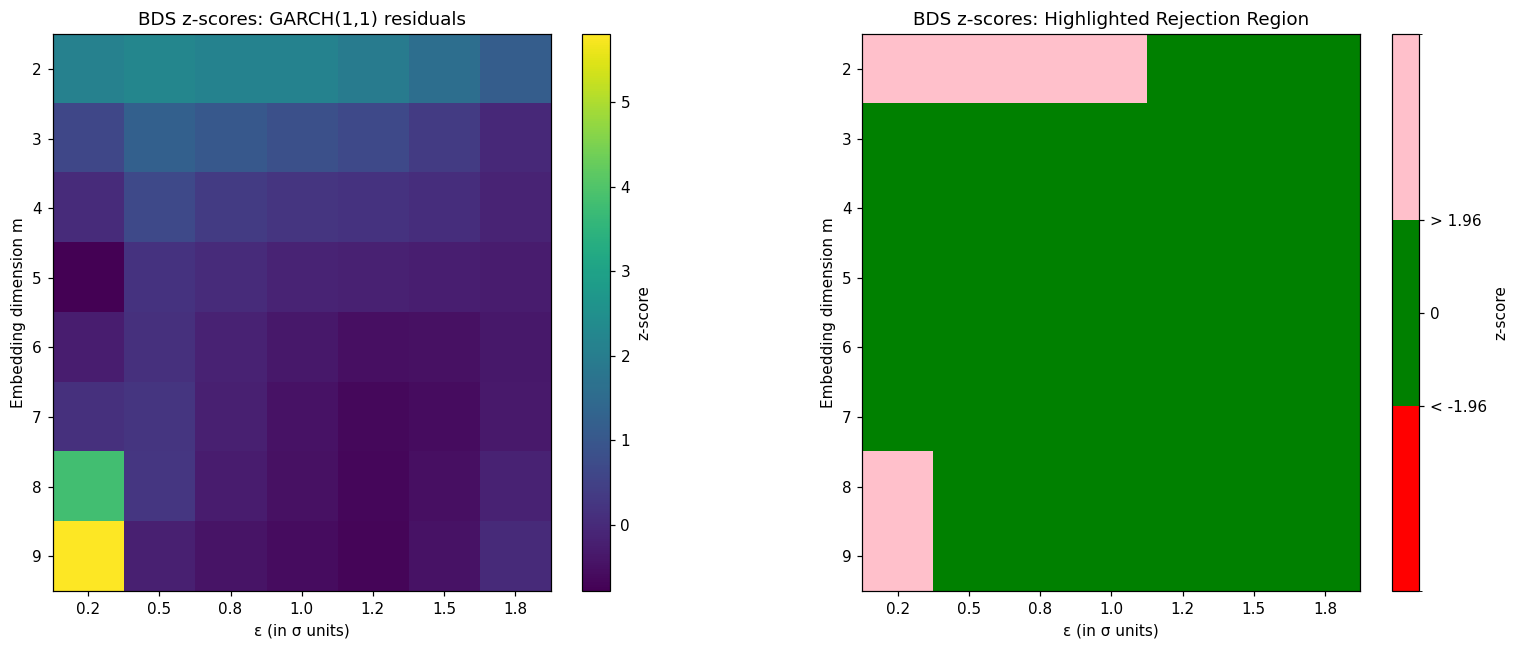

In [10]:
bds_gold_garch = bds_residuals_garch("GDX","GLD")
plot_bds_heatmaps(bds_gold_garch)

The residuals are mostly random but show nonlinear dependence in the same 
scales as before, but also in others, so while the linear model captures most
of the patterns in the data there are short term price actions it does not capture 
and that exhibit nonlinear dependence, this tells us one should trade this pair 
over medium to long term scales, which is what we intended to do as this is a 
mean return strategy, again we can visualize the change in $Z-scores$

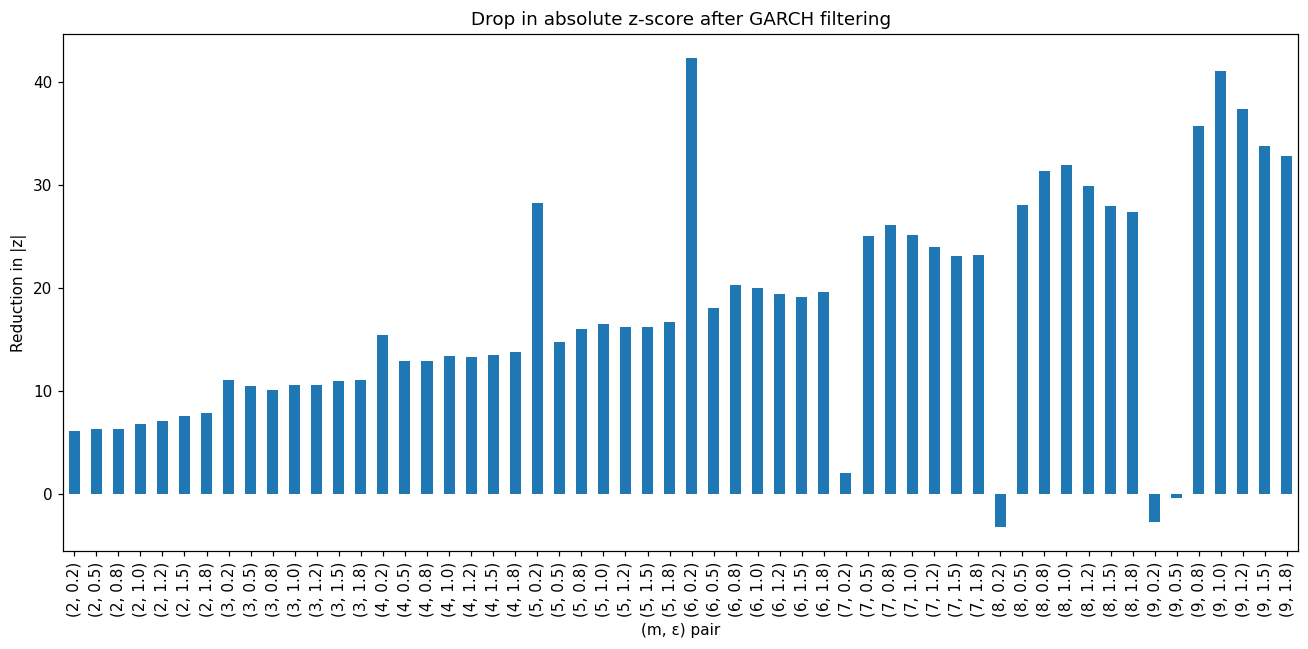

In [11]:
plot_reduction(bds_energy,bds_energy_garch)

### Technology ETFs

IYW on XLK Regression beta coefficient:  0.9986177988005368
We obtain a p value of 0.10286067179489719


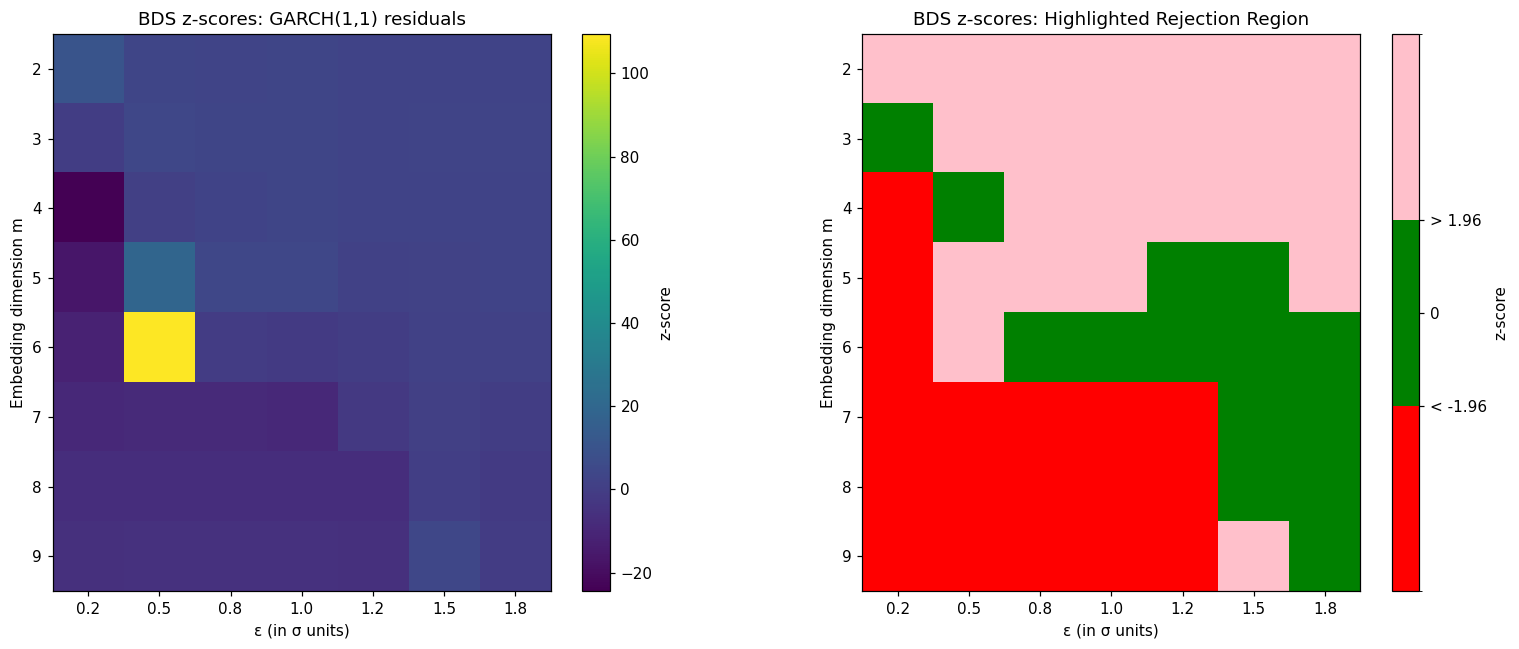

In [12]:
bds_tech_garch = bds_residuals_garch("IYW","XLK")
plot_bds_heatmaps(bds_tech_garch)

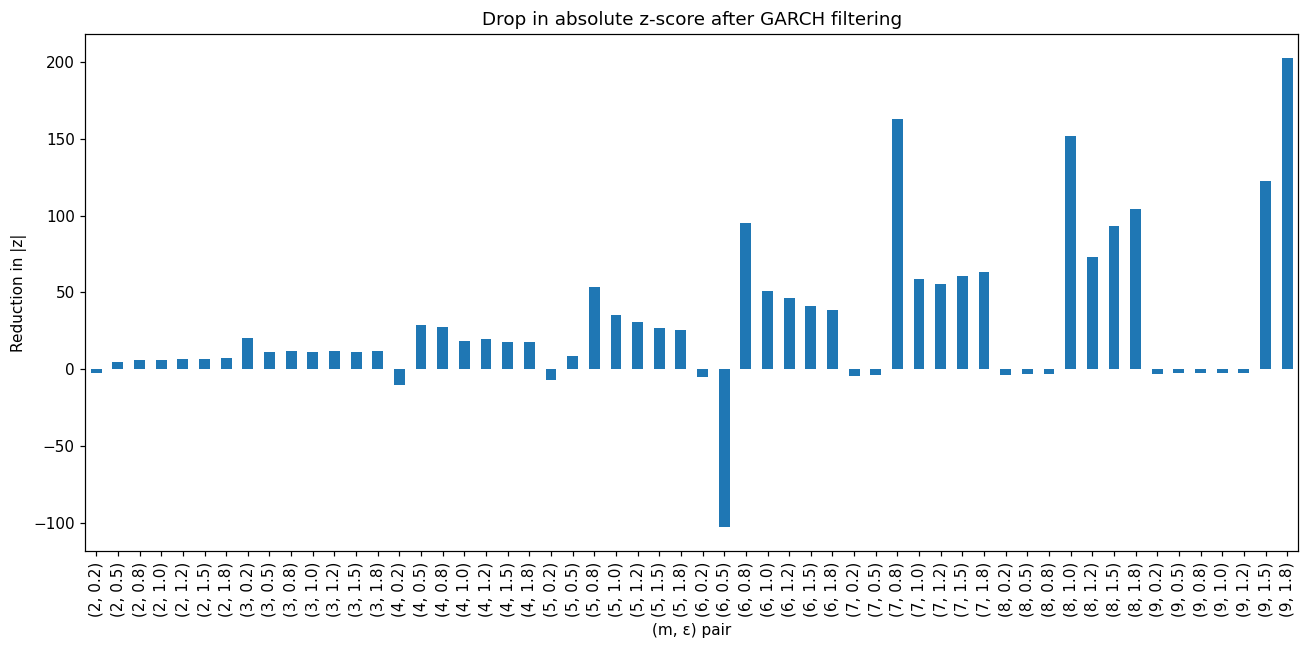

In [13]:
plot_reduction(bds_tech,bds_tech_garch)

Even though using a $GARCH(1,1)$ greatly reduced the magnitude of the $Z-scores$
as evidenced in the bar plot, this was not enough for this dataset as the heatmap
tells us, most od the scales exhibit nonlinear relationships in the spread beyond
volatility clustering, so we are missing patterns in our predictions when using 
a linear model in this dataset, if fact we do so most of the time, the $p\approx0.0976$
tells us the data is definitely not random, which means our model is not 
completely adequate for pair trading, due to missing, nonlinear relations, however
based on the $Z-values$ and their reduction, they are not the main driving force 
of returns, so we might still use it with low confidence

## References:

1. WQU "Capstone review module 5 Lesson 1"
2. [Statmodels documentation 0.15.0 (+753)](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.bds.html)
3. Using BDS statistics to detect nonlinearity in time series. Patrick Kuok Kun Chu. 98(2). International Statistical Institute proceedings 2001.
4. Broock, W. A., Scheinkman, J. A., Dechert, W. D., & LeBaron, B. (1996). A test for independence based on the correlation dimension. Econometric Reviews, 15(3), 197–235. 
